# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
from jax import numpy as np
#import numpy as np
import pickle
import math

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from calibrate import calibrate
from utils import read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc, visualize_results

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Uncomment if you do not want to access GPU
#os.environ["JAX_PLATFORMS"] = "cpu"

BATCH_SIZE = 64
EPOCHS = 3000
SEED = 0

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3200
}

## Select workload and read the circuits

Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1
loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

We read the circuits from the pickled files.

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training, validation and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Prepare circuits for the Lambeq optimizer

## Continuously optimize parameters

In [5]:
def get_symbols(circs):
    return set([sym for circuit in circs.values() for sym in circuit.free_symbols])


def construct_data_and_labels(circuits, labels):
    circuits_l = []
    data_labels_l = []
    for key in circuits:
        if key in labels:
            circuits_l.append(circuits[key])
            data_labels_l.append(labels[key])
    return circuits_l, data_labels_l


def select_circuits(base_circuits, selected_circuits):
    res = {}
    syms = get_symbols(base_circuits)
    for c in selected_circuits:
        s_syms = set(selected_circuits[c].free_symbols)
        if s_syms.difference(syms) == set():
            res[c] = selected_circuits[c]
    return res

Progress:  0.0
Number of training circuits: 58    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 238


Epoch 1:     train/loss: 1.0560   valid/loss: 1.1842   train/acc: 0.5172   valid/acc: 0.5463
Epoch 100:   train/loss: 0.6269   valid/loss: 1.0270   train/acc: 0.5862   valid/acc: 0.4444
Epoch 200:   train/loss: 0.5401   valid/loss: 0.9850   train/acc: 0.7069   valid/acc: 0.4815
Epoch 300:   train/loss: 0.5202   valid/loss: 0.9297   train/acc: 0.7759   valid/acc: 0.5000
Epoch 400:   train/loss: 0.4663   valid/loss: 0.9084   train/acc: 0.7414   valid/acc: 0.4907
Epoch 500:   train/loss: 0.4766   valid/loss: 0.8906   train/acc: 0.7586   valid/acc: 0.4907
Epoch 600:   train/loss: 0.4418   valid/loss: 0.8801   train/acc: 0.7931   valid/acc: 0.5000
Epoch 700:   train/loss: 0.4147   valid/loss: 0.8790   train/acc: 0.7931   valid/acc: 0.5185
Epoch 800:   train/loss: 0.4104   valid/loss: 0.8805   train/acc: 0.7931   valid/acc: 0.5370
Epoch 900:   train/loss: 0.4116   valid/loss: 0.8914   train/acc: 0.8103   valid/acc: 0.5556
Epoch 1000:  train/loss: 0.3969   valid/loss: 0.8935   train/acc: 0.84

Test accuracy: 0.5462963
Progress:  0.0
Progress:  0.0
Progress:  0.01
Progress:  0.01
Progress:  0.01
Progress:  0.01
Progress:  0.02
Progress:  0.02
Progress:  0.02
Progress:  0.02
Progress:  0.02
Progress:  0.03
Progress:  0.03
Progress:  0.03
Progress:  0.03
Progress:  0.04
Progress:  0.04
Progress:  0.04
Progress:  0.04
Progress:  0.04
Progress:  0.05
Progress:  0.05
Progress:  0.05
Progress:  0.05
Progress:  0.06
Progress:  0.06
Progress:  0.06
Progress:  0.06
Progress:  0.06
Progress:  0.07
Progress:  0.07
Progress:  0.07
Progress:  0.07
Progress:  0.08
Progress:  0.08
Progress:  0.08
Progress:  0.08
Progress:  0.08
Progress:  0.09
Progress:  0.09
Progress:  0.09
Progress:  0.09
Progress:  0.1
Number of training circuits: 101    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 241


Epoch 1:     train/loss: 0.8644   valid/loss: 0.9352   train/acc: 0.4851   valid/acc: 0.3889
Epoch 100:   train/loss: 0.6250   valid/loss: 0.6493   train/acc: 0.6139   valid/acc: 0.5926
Epoch 200:   train/loss: 0.5896   valid/loss: 0.6490   train/acc: 0.7030   valid/acc: 0.6019
Epoch 300:   train/loss: 0.5584   valid/loss: 0.6520   train/acc: 0.6832   valid/acc: 0.5741
Epoch 400:   train/loss: 0.5435   valid/loss: 0.6575   train/acc: 0.7327   valid/acc: 0.5833
Epoch 500:   train/loss: 0.5241   valid/loss: 0.6601   train/acc: 0.7228   valid/acc: 0.6019
Epoch 600:   train/loss: 0.5181   valid/loss: 0.6573   train/acc: 0.7327   valid/acc: 0.6111
Epoch 700:   train/loss: 0.5067   valid/loss: 0.6595   train/acc: 0.7030   valid/acc: 0.6111
Epoch 800:   train/loss: 0.5081   valid/loss: 0.6560   train/acc: 0.7129   valid/acc: 0.6111
Epoch 900:   train/loss: 0.4923   valid/loss: 0.6563   train/acc: 0.7426   valid/acc: 0.6111
Epoch 1000:  train/loss: 0.4960   valid/loss: 0.6543   train/acc: 0.72

Test accuracy: 0.712963
Progress:  0.1
Progress:  0.1
Progress:  0.1
Progress:  0.1
Progress:  0.11
Progress:  0.11
Progress:  0.11
Progress:  0.11
Progress:  0.12
Progress:  0.12
Progress:  0.12
Progress:  0.12
Progress:  0.12
Progress:  0.13
Progress:  0.13
Progress:  0.13
Progress:  0.13
Progress:  0.14
Progress:  0.14
Progress:  0.14
Progress:  0.14
Number of training circuits: 122    Number of validation circuits: 109    Number of test circuits: 109    Number of parameters in model: 244


Epoch 1:     train/loss: 1.1622   valid/loss: 1.1328   train/acc: 0.5082   valid/acc: 0.4771
Epoch 100:   train/loss: 0.7259   valid/loss: 0.6709   train/acc: 0.5410   valid/acc: 0.6606
Epoch 200:   train/loss: 0.6952   valid/loss: 0.7109   train/acc: 0.5492   valid/acc: 0.6422
Epoch 300:   train/loss: 0.6545   valid/loss: 0.6961   train/acc: 0.6148   valid/acc: 0.6239
Epoch 400:   train/loss: 0.6426   valid/loss: 0.6915   train/acc: 0.5984   valid/acc: 0.6055
Epoch 500:   train/loss: 0.6435   valid/loss: 0.6801   train/acc: 0.6230   valid/acc: 0.5872
Epoch 600:   train/loss: 0.6290   valid/loss: 0.6925   train/acc: 0.6557   valid/acc: 0.5963
Epoch 700:   train/loss: 0.6644   valid/loss: 0.7194   train/acc: 0.6148   valid/acc: 0.5963
Epoch 800:   train/loss: 0.6262   valid/loss: 0.6930   train/acc: 0.6148   valid/acc: 0.5963
Epoch 900:   train/loss: 0.6145   valid/loss: 0.7044   train/acc: 0.6230   valid/acc: 0.5963
Epoch 1000:  train/loss: 0.6148   valid/loss: 0.7021   train/acc: 0.63

Test accuracy: 0.5688073
Progress:  0.15
Progress:  0.15
Number of training circuits: 124    Number of validation circuits: 110    Number of test circuits: 109    Number of parameters in model: 253


Epoch 1:     train/loss: 0.9438   valid/loss: 1.1799   train/acc: 0.4677   valid/acc: 0.3727
Epoch 100:   train/loss: 0.7009   valid/loss: 0.7351   train/acc: 0.5484   valid/acc: 0.4455
Epoch 200:   train/loss: 0.6874   valid/loss: 0.7119   train/acc: 0.5726   valid/acc: 0.4636
Epoch 300:   train/loss: 0.6820   valid/loss: 0.6998   train/acc: 0.5645   valid/acc: 0.5000
Epoch 400:   train/loss: 0.6811   valid/loss: 0.6929   train/acc: 0.5806   valid/acc: 0.5182
Epoch 500:   train/loss: 0.6806   valid/loss: 0.6880   train/acc: 0.5887   valid/acc: 0.5182
Epoch 600:   train/loss: 0.6756   valid/loss: 0.6848   train/acc: 0.5806   valid/acc: 0.5273
Epoch 700:   train/loss: 0.6706   valid/loss: 0.6825   train/acc: 0.6290   valid/acc: 0.5273
Epoch 800:   train/loss: 0.6725   valid/loss: 0.6815   train/acc: 0.6290   valid/acc: 0.5364
Epoch 900:   train/loss: 0.6708   valid/loss: 0.6795   train/acc: 0.6210   valid/acc: 0.5273
Epoch 1000:  train/loss: 0.6691   valid/loss: 0.6774   train/acc: 0.65

Test accuracy: 0.55045867
Progress:  0.15
Progress:  0.15
Progress:  0.15
Progress:  0.16
Progress:  0.16
Progress:  0.16
Progress:  0.16
Progress:  0.17
Progress:  0.17
Progress:  0.17
Number of training circuits: 134    Number of validation circuits: 111    Number of test circuits: 110    Number of parameters in model: 268


Epoch 1:     train/loss: 0.9310   valid/loss: 0.9556   train/acc: 0.5373   valid/acc: 0.4054
Epoch 100:   train/loss: 0.7171   valid/loss: 0.6683   train/acc: 0.5522   valid/acc: 0.5766
Epoch 200:   train/loss: 0.6517   valid/loss: 0.6292   train/acc: 0.5821   valid/acc: 0.6126
Epoch 300:   train/loss: 0.6326   valid/loss: 0.6254   train/acc: 0.5746   valid/acc: 0.6126
Epoch 400:   train/loss: 0.6518   valid/loss: 0.6373   train/acc: 0.6045   valid/acc: 0.6036
Epoch 500:   train/loss: 0.6232   valid/loss: 0.6424   train/acc: 0.6119   valid/acc: 0.5856
Epoch 600:   train/loss: 0.6123   valid/loss: 0.6328   train/acc: 0.6194   valid/acc: 0.6036
Epoch 700:   train/loss: 0.6155   valid/loss: 0.6291   train/acc: 0.5821   valid/acc: 0.6126
Epoch 800:   train/loss: 0.6330   valid/loss: 0.6258   train/acc: 0.5224   valid/acc: 0.6216
Epoch 900:   train/loss: 0.6368   valid/loss: 0.6263   train/acc: 0.5821   valid/acc: 0.6216
Epoch 1000:  train/loss: 0.6114   valid/loss: 0.6305   train/acc: 0.60

Test accuracy: 0.6272727
Progress:  0.17
Progress:  0.17
Progress:  0.18
Progress:  0.18
Progress:  0.18
Progress:  0.18
Progress:  0.19
Progress:  0.19
Progress:  0.19
Progress:  0.19
Progress:  0.19
Progress:  0.2
Progress:  0.2
Progress:  0.2
Progress:  0.2
Progress:  0.21
Progress:  0.21
Progress:  0.21
Progress:  0.21
Progress:  0.21
Progress:  0.22
Progress:  0.22
Progress:  0.22
Progress:  0.22
Progress:  0.23
Progress:  0.23
Progress:  0.23
Progress:  0.23
Progress:  0.23
Progress:  0.24
Progress:  0.24
Progress:  0.24
Progress:  0.24
Progress:  0.25
Progress:  0.25
Progress:  0.25
Progress:  0.25
Progress:  0.25
Progress:  0.26
Progress:  0.26
Progress:  0.26
Progress:  0.26
Number of training circuits: 176    Number of validation circuits: 113    Number of test circuits: 111    Number of parameters in model: 271


Epoch 1:     train/loss: 0.9006   valid/loss: 0.8677   train/acc: 0.5000   valid/acc: 0.5044
Epoch 100:   train/loss: 0.7320   valid/loss: 0.7918   train/acc: 0.5455   valid/acc: 0.4956
Epoch 200:   train/loss: 0.6843   valid/loss: 0.7809   train/acc: 0.6080   valid/acc: 0.4867
Epoch 300:   train/loss: 0.6816   valid/loss: 0.7710   train/acc: 0.6023   valid/acc: 0.5133
Epoch 400:   train/loss: 0.6582   valid/loss: 0.7634   train/acc: 0.6080   valid/acc: 0.5221
Epoch 500:   train/loss: 0.6518   valid/loss: 0.7616   train/acc: 0.6080   valid/acc: 0.5133
Epoch 600:   train/loss: 0.6696   valid/loss: 0.7561   train/acc: 0.6136   valid/acc: 0.4690
Epoch 700:   train/loss: 0.6223   valid/loss: 0.7545   train/acc: 0.6250   valid/acc: 0.4513
Epoch 800:   train/loss: 0.6607   valid/loss: 0.7517   train/acc: 0.6136   valid/acc: 0.4425
Epoch 900:   train/loss: 0.6244   valid/loss: 0.7518   train/acc: 0.6136   valid/acc: 0.4602
Epoch 1000:  train/loss: 0.6120   valid/loss: 0.7492   train/acc: 0.64

Test accuracy: 0.5855856
Progress:  0.27
Progress:  0.27
Progress:  0.27
Progress:  0.27
Progress:  0.27
Progress:  0.28
Progress:  0.28
Progress:  0.28
Progress:  0.28
Progress:  0.29
Progress:  0.29
Progress:  0.29
Progress:  0.29
Progress:  0.29
Progress:  0.3
Progress:  0.3
Progress:  0.3
Progress:  0.3
Progress:  0.31
Progress:  0.31
Progress:  0.31
Progress:  0.31
Progress:  0.31
Progress:  0.32
Progress:  0.32
Progress:  0.32
Progress:  0.32
Progress:  0.33
Progress:  0.33
Progress:  0.33
Progress:  0.33
Progress:  0.33
Progress:  0.34
Progress:  0.34
Progress:  0.34
Progress:  0.34
Progress:  0.35
Progress:  0.35
Progress:  0.35
Progress:  0.35
Progress:  0.35
Progress:  0.36
Progress:  0.36
Progress:  0.36
Progress:  0.36
Progress:  0.37
Progress:  0.37
Progress:  0.37
Progress:  0.37
Progress:  0.38
Progress:  0.38
Progress:  0.38
Progress:  0.38
Progress:  0.38
Progress:  0.39
Progress:  0.39
Progress:  0.39
Progress:  0.39
Progress:  0.4
Progress:  0.4
Progress:  0.4
Progre

Epoch 1:     train/loss: 0.9037   valid/loss: 1.0522   train/acc: 0.6082   valid/acc: 0.5221
Epoch 100:   train/loss: 0.7012   valid/loss: 0.7472   train/acc: 0.6345   valid/acc: 0.6195
Epoch 200:   train/loss: 0.6282   valid/loss: 0.7119   train/acc: 0.6754   valid/acc: 0.6372
Epoch 300:   train/loss: 0.6209   valid/loss: 0.7000   train/acc: 0.6520   valid/acc: 0.6195
Epoch 400:   train/loss: 0.5896   valid/loss: 0.6818   train/acc: 0.6667   valid/acc: 0.6549
Epoch 500:   train/loss: 0.5999   valid/loss: 0.6881   train/acc: 0.6696   valid/acc: 0.6814
Epoch 600:   train/loss: 0.5773   valid/loss: 0.6958   train/acc: 0.6988   valid/acc: 0.6814
Epoch 700:   train/loss: 0.5677   valid/loss: 0.6826   train/acc: 0.7339   valid/acc: 0.6903
Epoch 800:   train/loss: 0.5754   valid/loss: 0.6907   train/acc: 0.6842   valid/acc: 0.6814
Epoch 900:   train/loss: 0.5524   valid/loss: 0.6769   train/acc: 0.7398   valid/acc: 0.6637
Epoch 1000:  train/loss: 0.5844   valid/loss: 0.6678   train/acc: 0.66

Test accuracy: 0.6306307
Progress:  0.64
Progress:  0.64
Progress:  0.64
Progress:  0.65
Progress:  0.65
Progress:  0.65
Progress:  0.65
Progress:  0.65
Progress:  0.66
Progress:  0.66
Progress:  0.66
Progress:  0.66
Progress:  0.67
Progress:  0.67
Progress:  0.67
Progress:  0.67
Progress:  0.67
Progress:  0.68
Progress:  0.68
Progress:  0.68
Progress:  0.68
Progress:  0.69
Progress:  0.69
Progress:  0.69
Progress:  0.69
Progress:  0.69
Progress:  0.7
Progress:  0.7
Progress:  0.7
Progress:  0.7
Progress:  0.71
Progress:  0.71
Progress:  0.71
Progress:  0.71
Progress:  0.71
Progress:  0.72
Progress:  0.72
Progress:  0.72
Progress:  0.72
Progress:  0.73
Progress:  0.73
Progress:  0.73
Progress:  0.73
Progress:  0.73
Progress:  0.74
Progress:  0.74
Progress:  0.74
Progress:  0.74
Progress:  0.75
Progress:  0.75
Progress:  0.75
Progress:  0.75
Progress:  0.75
Progress:  0.76
Progress:  0.76
Progress:  0.76
Progress:  0.76
Number of training circuits: 399    Number of validation circuits: 

Epoch 1:     train/loss: 0.8227   valid/loss: 0.8615   train/acc: 0.6040   valid/acc: 0.4602
Epoch 100:   train/loss: 0.7505   valid/loss: 0.7985   train/acc: 0.5514   valid/acc: 0.4425
Epoch 200:   train/loss: 0.6968   valid/loss: 0.7688   train/acc: 0.5539   valid/acc: 0.4513
Epoch 300:   train/loss: 0.7042   valid/loss: 0.7599   train/acc: 0.5514   valid/acc: 0.4513
Epoch 400:   train/loss: 0.6904   valid/loss: 0.7496   train/acc: 0.6065   valid/acc: 0.4513
Epoch 500:   train/loss: 0.6799   valid/loss: 0.7446   train/acc: 0.5589   valid/acc: 0.4602
Epoch 600:   train/loss: 0.6734   valid/loss: 0.7414   train/acc: 0.5865   valid/acc: 0.4602
Epoch 700:   train/loss: 0.6725   valid/loss: 0.7377   train/acc: 0.5990   valid/acc: 0.4690
Epoch 800:   train/loss: 0.6727   valid/loss: 0.7342   train/acc: 0.5739   valid/acc: 0.4867
Epoch 900:   train/loss: 0.6739   valid/loss: 0.7320   train/acc: 0.6190   valid/acc: 0.5133
Epoch 1000:  train/loss: 0.6797   valid/loss: 0.7296   train/acc: 0.55

Test accuracy: 0.5803572
Progress:  0.77
Progress:  0.77
Progress:  0.77
Progress:  0.77
Progress:  0.77
Progress:  0.78
Progress:  0.78
Progress:  0.78
Progress:  0.78
Progress:  0.79
Progress:  0.79
Progress:  0.79
Progress:  0.79
Progress:  0.79
Progress:  0.8
Progress:  0.8
Progress:  0.8
Progress:  0.8
Progress:  0.81
Progress:  0.81
Progress:  0.81
Progress:  0.81
Progress:  0.81
Progress:  0.82
Progress:  0.82
Progress:  0.82
Progress:  0.82
Progress:  0.83
Progress:  0.83
Progress:  0.83
Progress:  0.83
Progress:  0.83
Progress:  0.84
Progress:  0.84
Progress:  0.84
Progress:  0.84
Progress:  0.85
Progress:  0.85
Progress:  0.85
Progress:  0.85
Progress:  0.85
Progress:  0.86
Progress:  0.86
Progress:  0.86
Progress:  0.86
Progress:  0.87
Progress:  0.87


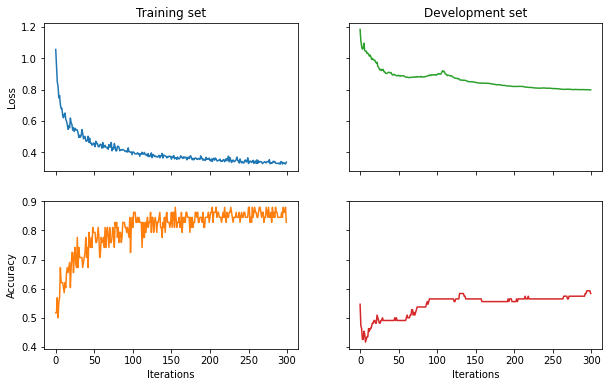

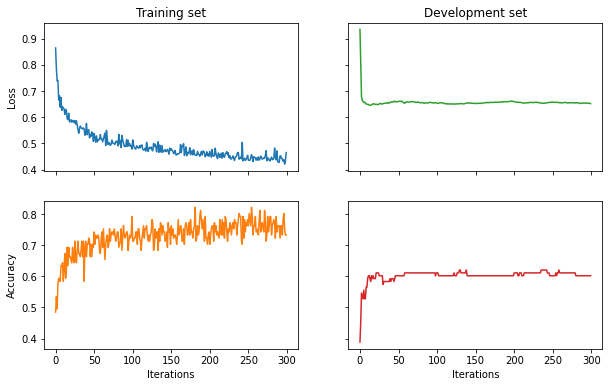

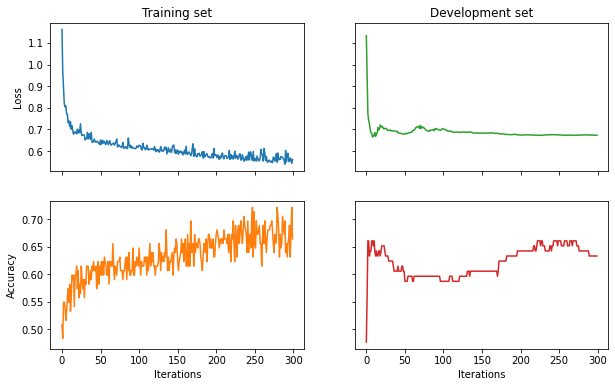

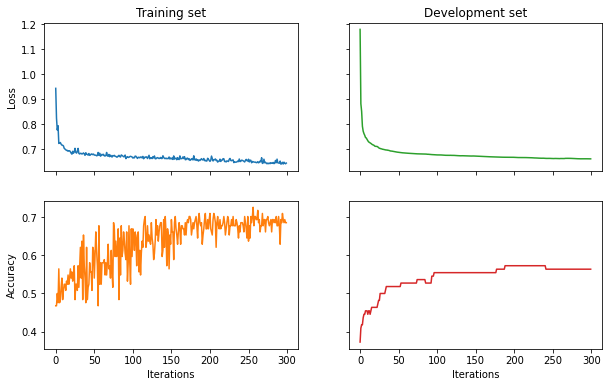

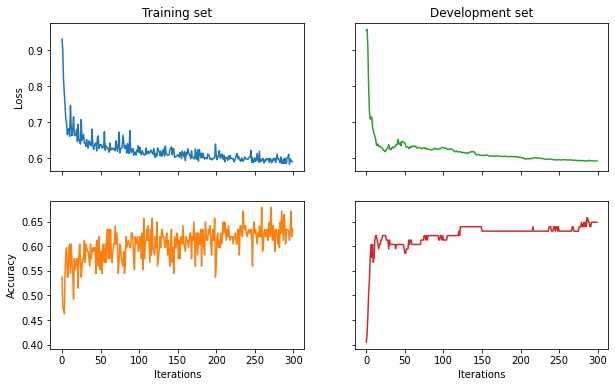

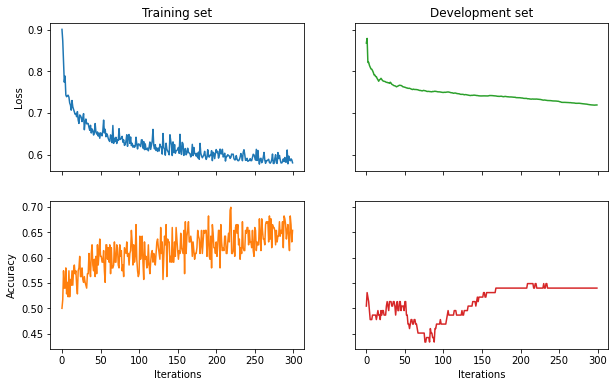

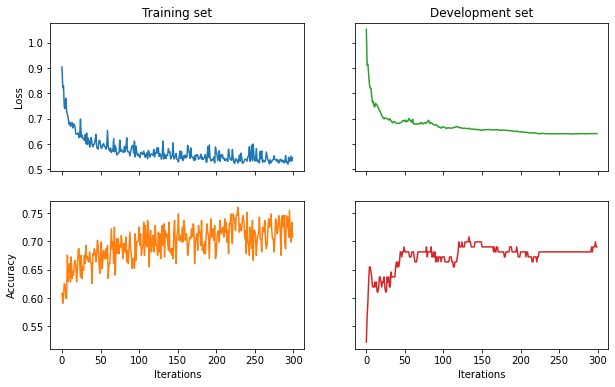

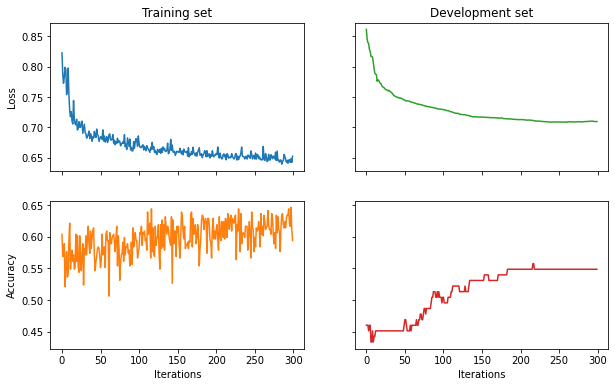

In [6]:
eval_metrics = {"acc": acc}
syms = {}

all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:58]

current_training_circuits = {}
for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]

run = 28
for i, key in enumerate(all_training_keys[58:]):
    print("Progress: ", round(i/len(all_training_keys), 2))
    current_training_circuits[key] = training_circuits[key]
    
    if run == 0:
        syms = get_symbols(current_training_circuits)
    else:
        if len(syms) == len(get_symbols(current_training_circuits)):
            continue
        else:
            run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    print(f"Number of training circuits: {len(training_circuits_l)}   ",
          f"Number of validation circuits: {len(validation_circuits_l)}   ",
          f"Number of test circuits: {len(test_circuits_l)}   ",
          f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}")
    
    # Select model
    #model = TketModel.from_diagrams(training_circuits_l, backend_config = backend_config)
    model = NumpyModel.from_diagrams(training_circuits_l, use_jit=True)
    
    # Initialize the weights from the possible previous training checkpoint
    if run > 0:
        model.from_checkpoint(this_folder + "//training_checkpoints//" + workload + "//checkpoint_" + str(run - 1) + ".chk")
    else:
        model.initialise_weights()
    
    trainer = QuantumTrainer(
        model,
        loss_function=loss,
        epochs=EPOCHS,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a': 0.0053, 'c': 0.0185, 'A':0.01*EPOCHS},
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose = 'text',
        seed=SEED
        )
    
    train_dataset = Dataset(training_circuits_l, training_data_labels_l)
    val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
    trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)
    checkpoint_path = this_folder + "//training_checkpoints//" + workload + "//checkpoint_" + str(run) + ".chk"
    model.make_checkpoint(checkpoint_path)
    figure_path = this_folder + "//results//" + workload_size + "_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params) + "_" + str(run) + ".png"
    visualize_results(model, trainer, test_circuits_l, test_data_labels_l, acc, figure_path)
    syms = get_symbols(current_training_circuits)

## Select the model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

## Define loss function and evaluation metrics

## Initialize the trainer and the datasets

## Train the model and visualize